# Homework 3

All code is located under the writeup. It is labeled appropiately

## Question 1: Change Point Detection

### Formulate the problem and generate data for training. Your training data should be sequences generated in the above way, where the change point occurs somewhere between T = 0 and T = 100, or not at all.

Refer to code below write up

### Build and train a recurrent neural network model to solve the problem

Refer to Figure 1 for model training and testing loss

### Results

Final Training Loss: ~0.36

Final Testing Loss: ~0.37

### Model Architecture

First Model Architecture (FMA):

1 LSTM Layer into Linear funnel classifier (100 -> 50 -> 20 -> 1)



VV Final Model Architecture VV

Second Model Architecture (SMA):

3 LSTM Layers into Linear funnel classifier (2000 -> 1500 -> 1000 -> 500 -> 100 -> 1)

m_hidden_size=10

m_LSTM_layers=5

m_LSTM_dropout=0

m_linear_dropout=0

is_bidirectional = False

learning_rate = 5e-4

m_batch_size = 32


Third Model Architecture (TMA):

1 LSTM Layer into Linear funnel classifier (2000 -> 1500 -> 1000 -> 500 -> 100 -> 1)

I decided to keep the model design simple since the task was also pretty simple. If I were to make the model way too big, I feared that it would start overfitting on the data. As a consequence, I believe this might have been the reason my model was stuck at ~0.36 loss.

### Model Training

For the first training loop, I started with no dropout and kept the learning rate at 1e-3 to see where the model could go. After the 20th epoch, I noticed that the model could no longer get a training and testing loss lower than ~0.37 and would keep oscillating from there on. As such, I decided to decrease the learning rate to 5e-4 but the loss kept oscillating. This caused me to switch the model architecture from FMA to SMA.

On the first training loop, the model was able to get a new low training loss of ~0.36 but the testing loss was only able to get to ~0.37. However, one thing I noticed was that it took a few epochs for the model to get lower than 0.70 loss, so I decided to increase the learning rate to 1e-2 but the model was never able to get past 0.70 loss. Because of this, I decided to experiment with different sizes of LSTM layers, but noticed that the more LSTM layers I added the more prone the model was to being stuck at 0.70 loss. Finally, I decided to switch from SMA to TMA.

For this training loop, I decided to keep the learning rate at 5e-4, linear dropout of 0.25, and add a weight decay of 5e-4, but again the loss would not go lower than 0.36. Instead of trying to change the model architecture, I focused on tinkering with batch size, data size, weight decay, and dropout. Sadly, none of these helped with lower in the model loss. Interestingly, I noticed that increasing the data size did not really help the model all too much, suggesting that the amount of data I gave the model was enough.

For this model, I noticed that making it bidirectional prevented it from learning past a loss of ~0.68. I believe that this feature does not really help with anomaly detection but I can not really put into words why that is the case.



### A good visualization of performance here is a plot of ’detection probability’ as a function of ’distance from the change point’. What was the detection probability 5 timesteps before the change point? 4 timesteps? 1 timestep? At the change point? 5 timesteps after the change point? Create a plot with ”time from change” on the x axis, from say [−10, 10], and ”probability of changepoint having occurred” on the y axis.

Refer to Figure 2 for this question

### Build and train a 1D-CNN neural network to solve this problem.

Refer to Figure 3 for model training and testing loss during training

### Results

Final Training Loss: ~0.46

Final Testing Loss: ~0.47

### Model Architecture

First Model Architecture (FMA):

2x CNN Layers with channels (32 -> 64) + Classifier Linear Funnel Head 256 -> 100 -> 50 -> 10 -> 1)

Second Model Architecture (SMA):

2x CNN Layers with channels (64 -> 128) + Classifier Linear Funnel Head (256 -> 100 -> 50 -> 10 -> 1)

Linear Classifier had Normalization layers for all layers except the output layer

Third Model Architecture (TMA):

3x CNN Layers with channels (64 -> 256 -> 512) + Classifier Linear Funnel Head 256 -> 100 -> 50 -> 10 -> 1)

Linear Classifier had Normalization layers for all layers except the output layer

### Model Training

For the FMA’s first training loop, I decided to use a learning rate of 1e-3, but ran into an immediate issue of the testing loss blowing up the second the model went past the second epoch. Because of this behavior, I decided to test with a slower learning rate of 5e-4 but the same issue occurred. Immediately, I decided to add a dropout of 0.25 to the model which slightly helped but after the 4th epoch, the same thing happened. In order to further counteract the loss explosion, I switched to SMA.

Using SMA, I decided to keep the same learning rate and kept a dropout of 0.25 on both the CNN and Linear layers. By the 5th epoch, the model was able to reach a training loss of ~0.46 and a testing loss of ~0.47, but beyond this epoch, the model would start overtraining and the testing loss would fluctuate erratically. For the second training loop, I tried increasing the dropout from 0.25 to 0.30 and decreasing the learning rate from 1e-3 to 5e-4, but came across the same issue. Because changing model hyperparameters was not doing me any good, I thought that maybe I was being bottlenecked by the model’s lack of complexity. So, I decided to switch to TMA.

For TMA, I kept the same hyperparameters as stated previously and saw that the testing loss no longer behaved erratically while testing, but instead would show signs of clear overfitting. Sadly, I was still stuck at the same training and testing losses as the SMA. Since I had not altered the linear layers yet, I tried to make the linear layers have an hourglass pattern where I blew up the dimensions and then shrunk it. Surprisingly, this made it so that the model could no longer learn past ~0.70 loss. From this point, I tried experimenting with all kinds of different model architecture in terms of increasing and decreasing CNN and Linear layers, but could never get a loss lower than ~0.46.


### Same visualization as before. How can you account for not having enough terms in the sequence early on for your convolutional window?

Refer to Figure 4 for this question.

I can account for not having enough terms in the sequence early for my convolution window by using padding which can be specified to the model for each CNN layer via PyTorch.

### Which network worked better? Why? Which network is better able to detect change points outside the time horizon it was trained on

The LSTM model outperformed the 1D-CNN model since it had a final testing loss of ~0.37 as compared to the CNN's final testing loss of ~0.47. The reason I believe that the LSTM worked better was simply because the task at hand is more suitable for the LSTM which is designed to be able to make a good summary matrix out of a sequence of some data that can then be given to some classifier that can make a final decision on if the sequence had an anomaly. If we consider the 1D-CNN, it is only able to compute local features of the sequential data which can lose or overlook some relationship in the sequential data that is necessary to come to a proper conclusion.

#### Time Horizon Task Results

LSTM Final Testing Loss: 0.2160

1D-CNN Final Testing Loss: 0.3686

The LSTM was able to outperform the 1D-CNN in the new time horizon task.

## Question 2: Summarization

### Show that you can write code for summary and query that doesn’t rely on neural networks at all, and is perfectly accurate.

In [2]:
from collections import Counter
import torch

def generate_int_sequence(sequence_length: int = 10) -> torch.Tensor:

    return torch.randint(0, 8, size=(sequence_length, ), dtype=torch.int64)

def summerize(sequence: torch.Tensor) -> dict:

    vector_list = sequence.tolist()

    return Counter(vector_list)

def query(vectory_summary: dict, queried_int: int) -> bool:

    return True if vectory_summary[queried_int] > 0 else False

summary = summerize(generate_int_sequence(10))
print(query(summary, 1))


False


### Define a 2D embedding for the numbers 0 through 9, and a summary network that takes a sequence of integers, applies the embedding, then computes a recurrent network on the sequence to give a summary vector output. Similarly, define a query network that takes as input the output of summary, and an embedded integer q, and returns a probability that q occurred in that sequence.

Note: For the sake of training, the Summary and Query neural nets live in a singular network, however, they are individually accessible.

Refer to Figure 1 for training and testing loss graph

### Results

Final Training Loss: ~0.0012

Final Testing Loss: ~0.0000

### Model Architecture

First Model Architecture (FMA):

1x LSTM Layer into 5x Linear Layers (200 -> 200 -> 100 -> 50 -> 1)

VVV Final Model VVV

Second Model Architecture (SMA):

3x LSTM Layer into 5x Linear Layers (200 -> 200 -> 100 -> 50 -> 1)

m3_hidden_size = 10

m3_LSTM_layers = 3

m3_LSTM_dropout = 0

m3_linear_dropout = 0

is_bidirectional = True

m3_learning_rate = 1e-3


### Model Training

For the first training loop, I set the learning rate to 5e-4 with no additional features such as dropout, layer normalization, or bidirectional reading and was able to reach a training and testing loss of ~0.03 by the 30h epoch. However, I noticed that the model didn’t seem to slow down in optimization by that point, so I decided to train it for longer. At the 50th epoch, the model got a training and testing loss of ~0.028. Throughout the training loop, I saw that the loss was steadily going lower and lower, so I tried increasing the learning rate to see if there would be any benefit. Using a learning rate of 1e-3, the model was able to get a new low of ~0.026 and ~0.021 training and testing loss respectively yet was struggling to make it past the 0.02 loss barrier. This made me think that I needed a more complex model, so I switched to SMA.

Similar to FMA, the SMA model keeps the same linear layers and uses a learning rate of 1e-3  but does not use aforementioned tricks such as dropout, however, it now bidirectional since I thought that it would be beneficial to read the sequence both ways since it is a matter of encoding a good summary vector for the query to use. After training, the model was able to get an all-time low of ~0.0012 training loss and a testing loss ~0.0 at the 34th epoch. At this point, I was satisfied with the model’s performance and decided to keep it here.


### Repeat the same experiment, but the query network needs to test whether q and q + 1 occurred next to each other in the sequence.

### Train this new network. Are you successful? On a 2D axis, plot the embedding for the first problem, and the embedding for the second problem. Do you notice anything about where the different integers are embedded, between the two problems?

Refer to Figure 2 for model training and testing loss graph

### Results

Final Training Loss: ~0.0016

Final Testing Loss: ~0.0007

### Model Architecture

First Model Architecture (FMA):
	1x LSTM Layer into 5x Linear Layers (200 -> 200 -> 100 -> 50 -> 1)

VVV Final Model Architecture VVV

Second Model Architecture (SMA):
	3x LSTM Layer into 5x Linear Layers (200 -> 200 -> 100 -> 50 -> 1)

m4_hidden_size = 10

m4_LSTM_layers = 3

m4_LSTM_dropout = 0

m4_linear_dropout = 0

is_bidirectional = True

m4_learning_rate = 1e-3


### Model Training

For the FMA, I decided to start with a learning rate of 5e-4 and nothing more. After training, the model was able to reach a training and testing loss of ~0.12 and ~0.135 by the 29th epoch but was once again learning too slowly. With a learning rate of 1e-3, the model was able to get lower training and testing losses at ~0.10 and ~0.11 respectively. Instead of going directly to a new architecture, I wanted to see if adding bidirectional reading would be enough to at least pass the ~0.10 loss barrier. Using it, new testing and training losses of ~0.069 and ~0.08 were obtained at the 30th epoch. I could tell that at this rate, it would be better to switch to a better model in order to get better losses and quicker.

Using SMA, the model started with a learning rate of 1e-3 and bidirectional reading only and was able to quickly beat the old losses by the 6th epoch and reached a final training and testing loss of ~0.0016 and ~0.0007 at the 30th epoch. As can be seen, I could just increase the number of epochs I train the model and most likely reach losses like the previous question, however, since this is a matter of just letting the model train more, I decided against altering the model or its hyperparameters at this point.

### Thoughts

For both this model and the previous model, I saw that increasing the number of layers in the LSTM significantly helped the models break past loss barriers and get better losses at lower epochs.


### Embedding Visualization + Analysis

Refer to Figures 3 and 4 for the model's 3, the single query model,  and 4's, the double query (q, q+1) model, embedding graphs after training.

Looking at the first graph, I noticed that model 3’s embeddings are spaced out well. However, if we consider the numbers that are embedded near each other, we can see that numbers that typically come after each other in a sequence are closer to each other. For instance, (0, 1, 2) and (3, 4) are two clusters that show this.

For the second graph, the embeddings from model 4 are interestingly in the shape of a bird's foot. However, taking a closer look, we can see that some numbers that are closer together in value are nearer to each other on the graph. For example, (2, 3, 4, 5) are close to each other in the middle of the graph. Additionally, some pairs of numbers that have a difference of 5 in terms of value are closer to each other compared to other values. Pairs such as (2, 7), (3, 8), and (1, 6) share this characteristic.

 Between the two graphs, we can see that both models like embedding numbers that have smaller differences in value nearer to each other.


### Question 1 Code and Setup

Library Imports

In [5]:
from unicodedata import bidirectional

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as dist
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sympy.stats.rv import probability
from torch.nn.functional import adaptive_avg_pool1d
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.utils import data
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [6]:
# Verify that GPU is connected and available
print(torch.__version__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(torch.cuda.get_device_name(0))

2.5.1
NVIDIA GeForce RTX 4060 Laptop GPU


Data Generation and Collection for the first model

In [7]:
def generate_data(sequence_length: int, T: int, has_breakpoint: bool) -> torch.Tensor:
    '''
    Generated a sequence of 10-dim vectors of length sequence_length.

    :param sequence_length: Specified length of the sequence to be generated
    :param T: The breakpoint after which the sequence starts to behave differently
    :param has_breakpoint: Specifies whether the breakpoint is present in the sequence

    :return:
    '''

    # Setup normal dist
    normal_dist = dist.Normal(0, 1)
    # Make a normal set of vectors for the initial sequence
    normal_sequence = normal_dist.sample((sequence_length if not has_breakpoint else T, 10))

    if not has_breakpoint:
        return normal_sequence

    # Define the number of vectors after the breakpoint
    anomaly_length = sequence_length - T

    # A list to hold the post-T vectors
    sequence_list = []

    # Randomly select and generate indices and their means
    random_indices = np.random.choice(10, size=5, replace=False)
    random_means = np.random.uniform(-1, 1, size=5)

    for _ in range(anomaly_length):

        # Create a placeholder sequence
        random_sequence = normal_dist.sample((10,))

        # Override 5 default values
        for index, mean in zip(random_indices, random_means):
            random_sequence[index] = dist.Normal(mean, 1).sample()

        # Add the new vector to the list
        sequence_list.append(random_sequence)

    # Combine the post_T vectors into a Tensor of size (T-1, 10)
    post_T_sequence = torch.stack(sequence_list, dim=0)

    # Combines all vectors into a Tensor of size (T, 10)
    complete_sequence = torch.cat([normal_sequence, post_T_sequence], dim=0)

    return complete_sequence

class DataWrapper(data.Dataset):

    def __init__(self, zip):
        self.data = list(zip)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

def generate_data_tensors(num_of_sequences: int = 100, custom_sequence_range: range = range(1,101), mode: bool = False) -> DataWrapper:
    '''
    Generates the dataset for problem 1

    :param num_of_sequences: Number of sequences to be generated
    :param custom_sequence_range: Length of the sequence to be generated
    :param mode: Specifies which data to generate (False for train, True for test)


    :return:
    '''

    # Initialize list of records and labels
    list_of_x = []
    list_of_y = []

    # Declare the number of sequences to be generated for each sequence length
    NUM_OF_SEQUENCES = int(num_of_sequences if not mode else num_of_sequences / 3)

    for i in custom_sequence_range:

        # Generate sequences with no breakpoint
        for _ in range(NUM_OF_SEQUENCES):
            new_sequence = generate_data(i, 0 , False)

            list_of_x.append(new_sequence)
            list_of_y.append(torch.tensor(0.0, dtype=torch.float64))

        # Generate sequences with a breakpoint
        for _ in range(NUM_OF_SEQUENCES):
            new_sequence = generate_data(i, np.random.randint(0, i), True)

            list_of_x.append(new_sequence)
            list_of_y.append(torch.tensor(1.0, dtype=torch.float64))

    list_of_y = torch.stack(list_of_y, dim=0)

    return DataWrapper(zip(list_of_x, list_of_y))

def generate_padded_data(batch):

    # 1. Separate the data and labels
    data_tensors = [item[0] for item in batch]
    label_tensors = [item[1] for item in batch]

    # 2. Get original lengths
    lengths = torch.tensor([t.shape[0] for t in data_tensors], dtype=torch.int64)

    # 3. Sort lengths in DESCENDING order and get the permutation indices
    # This step is critical for pack_padded_sequence stability.
    lengths_sorted, sorted_idx = lengths.sort(descending=True)

    # 4. Sort the data and labels lists using the obtained indices
    data_tensors_sorted = [data_tensors[i] for i in sorted_idx]
    label_tensors_sorted = [label_tensors[i] for i in sorted_idx]

    # 5. Pad the sorted sequences
    padded_sequences = pad_sequence(data_tensors_sorted, batch_first=True, padding_value=0.0)

    # 6. Stack the sorted labels
    labels = torch.stack(label_tensors_sorted)

    # Return the three components, now correctly sorted
    return padded_sequences, lengths_sorted, labels


LSTM Model

In [8]:
class AnomalyDetectorLSTM(nn.Module):
    '''

    LSTM NN for Question 1

    '''

    def __init__(self,
                 input_size=10,
                 hidden_size=10,
                 LSTM_layers=1,
                 LSTM_dropout: float = 0,
                 linear_dropout: float = 0,
                 bidirectional=False
                 ):
        super().__init__()

        # Define the LSTM for the NN
        self.LSTM = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=LSTM_layers,
            dropout=LSTM_dropout,
            bidirectional=bidirectional,
            batch_first=True
        )

        self.layer_1_size = 100
        self.layer_2_size = 50
        self.layer_3_size = 20
        # self.layer_4_size = 2000
        # self.layer_5_size = 1500
        # self.layer_6_size = 1000
        # self.layer_7_size = 2000
        # self.layer_8_size = 500
        # self.layer_9_size = 100
        self.output_layer_size = 1

        self.classifier = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=self.layer_1_size),
            nn.ReLU(),
            nn.Dropout(p=linear_dropout),

            nn.Linear(in_features=self.layer_1_size, out_features=self.layer_2_size),
            nn.ReLU(),
            nn.Dropout(p=linear_dropout),

            nn.Linear(in_features=self.layer_2_size, out_features=self.layer_3_size),
            nn.ReLU(),
            nn.Dropout(p=linear_dropout),

            nn.Linear(in_features=self.layer_3_size, out_features=self.output_layer_size),
        )

    def forward(self, x, lengths):

        # Pack the padded data so that the LSTM can handle variable length sequences
        packed_input = pack_padded_sequence(
            x,
            lengths.cpu(),
            batch_first=True,
            enforce_sorted=False
        )

        # Grab the final outputs from the LSTM
        output, (h_n, c_n) = self.LSTM(packed_input)

        # Grab the summary of the sequences
        final_hidden_state = h_n[-1]

        # Compute the final label
        logits = self.classifier(final_hidden_state)

        logits = logits.squeeze(1)

        return logits




In [53]:
# Model Hyperparameter setup
m_hidden_size=10
m_LSTM_layers=1
m_LSTM_dropout=0
m_linear_dropout=0
is_bidirectional = False
# weight_decay = 5e-4

# Training Loop Hyperparameter setup
learning_rate = 5e-4
m_batch_size = 32
epochs = 30

# Data Requested
sequences_wanted = 200

m1_epoch_over_training_loss = []
m1_epoch_over_testing_loss = []

In [54]:
print('||| Generating model training data |||')

# Generate the model data
train_dataloader = DataLoader(
    generate_data_tensors(num_of_sequences=sequences_wanted),
    batch_size=m_batch_size,
    shuffle=True,
    collate_fn=generate_padded_data,
    pin_memory=True,
    num_workers=5
)

print('||| Model data generated |||')

print('||| Generating model testing data |||')

# Generate the model data
test_dataloader = DataLoader(
    generate_data_tensors(num_of_sequences=sequences_wanted, mode=True),
    batch_size=m_batch_size,
    shuffle=False,
    collate_fn=generate_padded_data,
    pin_memory=True,
    num_workers=5
)

print('||| Model data generated |||\n')

||| Generating model training data |||
||| Model data generated |||
||| Generating model testing data |||
||| Model data generated |||



LSTM Training Loop

In [55]:
# Setup model, optimizer, and loss function
model = AnomalyDetectorLSTM(
    hidden_size=m_hidden_size,
    LSTM_layers=m_LSTM_layers,
    LSTM_dropout=m_LSTM_dropout,
    linear_dropout=m_linear_dropout,
    bidirectional=is_bidirectional
).to(device)

loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(),
                        lr=learning_rate,
                        # weight_decay=weight_decay
                        )

print('########## Starting Training Loop for Anomaly Detection LSTM ##########\n')

for epoch in range(epochs):

    model.train()

    total_training_loss = 0
    total_testing_loss = 0

    avg_training_loss = 0
    avg_testing_loss = 0

    print(f'~~~~~ Epoch {epoch + 1}/{epochs} ~~~~~')

    for X_batch, length_batch, y_batch in tqdm(train_dataloader, desc='Training', unit=' batches'):
        optimizer.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.float().to(device)

        logits = model(X_batch, length_batch)

        loss = loss_function(logits, y_batch)

        with torch.no_grad():
            total_training_loss += loss.item()

        loss.backward()
        optimizer.step()

    model.eval()

    # Calc testing loss
    with torch.no_grad():
        for X_t_batch, length_t_batch, y_t_batch in tqdm(test_dataloader, desc='Testing', unit=' batches'):
                X_t_batch = X_t_batch.to(device)
                y_t_batch = y_t_batch.float().to(device)

                t_logits = model(X_t_batch, length_t_batch)

                total_testing_loss += loss_function(t_logits, y_t_batch).item()

        avg_training_loss = total_training_loss / len(train_dataloader)
        avg_testing_loss = total_testing_loss / len(test_dataloader)

    model.train()

    m1_epoch_over_training_loss.append({
        'epoch': epoch + 1,
        'training_loss': avg_training_loss,
    })

    m1_epoch_over_testing_loss.append({
        'epoch': epoch + 1,
        'testing_loss': avg_testing_loss,
    })

    print(f'     -> Training Loss: {avg_training_loss:.4f}\n')
    print(f'     -> Testing Loss: {avg_testing_loss:.4f}\n')

########## Starting Training Loop for Anomaly Detection LSTM ##########

~~~~~ Epoch 1/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 668.73 batches/s]


     -> Training Loss: 0.6208

     -> Testing Loss: 0.5350

~~~~~ Epoch 2/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 668.73 batches/s]


     -> Training Loss: 0.5191

     -> Testing Loss: 0.4981

~~~~~ Epoch 3/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 447.27 batches/s]


     -> Training Loss: 0.4916

     -> Testing Loss: 0.4838

~~~~~ Epoch 4/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 685.68 batches/s]


     -> Training Loss: 0.4756

     -> Testing Loss: 0.4692

~~~~~ Epoch 5/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 672.52 batches/s]


     -> Training Loss: 0.4629

     -> Testing Loss: 0.4578

~~~~~ Epoch 6/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 607.39 batches/s]


     -> Training Loss: 0.4496

     -> Testing Loss: 0.4443

~~~~~ Epoch 7/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 581.27 batches/s]


     -> Training Loss: 0.4374

     -> Testing Loss: 0.4399

~~~~~ Epoch 8/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 655.51 batches/s]


     -> Training Loss: 0.4238

     -> Testing Loss: 0.4278

~~~~~ Epoch 9/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 653.41 batches/s]


     -> Training Loss: 0.4152

     -> Testing Loss: 0.4157

~~~~~ Epoch 10/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 673.86 batches/s]


     -> Training Loss: 0.4090

     -> Testing Loss: 0.4102

~~~~~ Epoch 11/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 666.35 batches/s]


     -> Training Loss: 0.4047

     -> Testing Loss: 0.4060

~~~~~ Epoch 12/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 610.78 batches/s]


     -> Training Loss: 0.3991

     -> Testing Loss: 0.4060

~~~~~ Epoch 13/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 662.99 batches/s]


     -> Training Loss: 0.3960

     -> Testing Loss: 0.4017

~~~~~ Epoch 14/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 644.01 batches/s]


     -> Training Loss: 0.3923

     -> Testing Loss: 0.3934

~~~~~ Epoch 15/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 656.31 batches/s]


     -> Training Loss: 0.3875

     -> Testing Loss: 0.3978

~~~~~ Epoch 16/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 691.76 batches/s]


     -> Training Loss: 0.3859

     -> Testing Loss: 0.3930

~~~~~ Epoch 17/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 655.61 batches/s]


     -> Training Loss: 0.3833

     -> Testing Loss: 0.3863

~~~~~ Epoch 18/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 551.12 batches/s]


     -> Training Loss: 0.3825

     -> Testing Loss: 0.3852

~~~~~ Epoch 19/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 567.11 batches/s]


     -> Training Loss: 0.3799

     -> Testing Loss: 0.4039

~~~~~ Epoch 20/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 651.93 batches/s]


     -> Training Loss: 0.3801

     -> Testing Loss: 0.3929

~~~~~ Epoch 21/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 495.48 batches/s]


     -> Training Loss: 0.3780

     -> Testing Loss: 0.3868

~~~~~ Epoch 22/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 631.16 batches/s]


     -> Training Loss: 0.3772

     -> Testing Loss: 0.4032

~~~~~ Epoch 23/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 703.84 batches/s]


     -> Training Loss: 0.3776

     -> Testing Loss: 0.3874

~~~~~ Epoch 24/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 703.29 batches/s]


     -> Training Loss: 0.3763

     -> Testing Loss: 0.3847

~~~~~ Epoch 25/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 729.41 batches/s]


     -> Training Loss: 0.3756

     -> Testing Loss: 0.3847

~~~~~ Epoch 26/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 698.23 batches/s]


     -> Training Loss: 0.3749

     -> Testing Loss: 0.3847

~~~~~ Epoch 27/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 702.47 batches/s]


     -> Training Loss: 0.3735

     -> Testing Loss: 0.3974

~~~~~ Epoch 28/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 680.11 batches/s]


     -> Training Loss: 0.3725

     -> Testing Loss: 0.3902

~~~~~ Epoch 29/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 711.72 batches/s]


     -> Training Loss: 0.3738

     -> Testing Loss: 0.3841

~~~~~ Epoch 30/30 ~~~~~


Testing: 100%|██████████| 413/413 [00:00<00:00, 649.73 batches/s]

     -> Training Loss: 0.3724

     -> Testing Loss: 0.3845



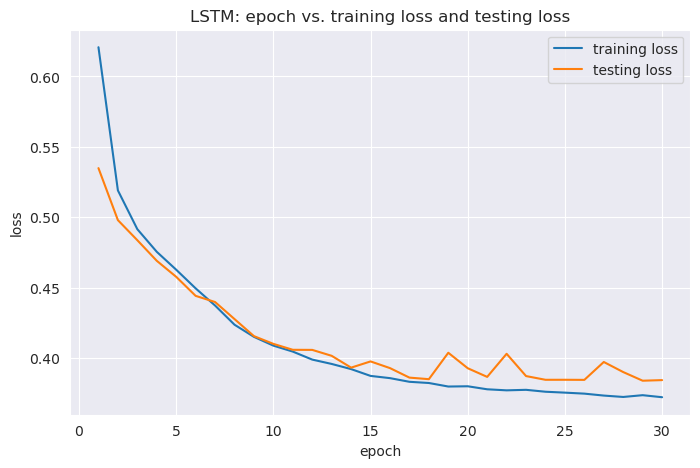

In [56]:
m1_x_axis = [d["epoch"] for d in m1_epoch_over_training_loss]
m1_y_axis_1 = [d["training_loss"] for d in m1_epoch_over_training_loss]
m1_y_axis_2 = [d["testing_loss"] for d in m1_epoch_over_testing_loss]

plt.figure(figsize=(8,5))
plt.title("LSTM: epoch vs. training loss and testing loss")
plt.plot(m1_x_axis, m1_y_axis_1, label="training loss")
plt.plot(m1_x_axis, m1_y_axis_2, label="testing loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()


plt.show()

Time Step Probability Detection Graphing for LSTM in Question 1

In [57]:
def generate_plot_data(num_of_sequences_requested: int = 100) -> DataWrapper:

    list_of_x = []
    list_of_y = []
    list_of_r = []

    for _ in range(num_of_sequences_requested):
        # The range of sequence lengths
        for i in range(20, 80, 2):

            # Get the sequence
            seq = generate_data(10 + i, i, True)

            # Get data from [-10, 10]
            for r in range(-10, 11, 1):
                list_of_x.append(
                    seq[ : i + r]
                )

                # Generate the label with the sequence slices
                list_of_y.append(torch.tensor(1.0, dtype=torch.float64))

                # Store the distance from the breakpoint
                list_of_r.append(r)


    # Combine labels
    list_of_y = torch.stack(list_of_y)

    return DataWrapper(zip(list_of_x, list_of_y, list_of_r))


def generate_padded_plot_data(batch):

    data_tensors = [item[0] for item in batch]
    label_tensors = [item[1] for item in batch]
    r_values = [item[2] for item in batch]

    data_lengths = torch.tensor([data.shape[0] for data in data_tensors], dtype=torch.int64)
    padded_sequence = pad_sequence(data_tensors, batch_first=True, padding_value=0)

    labels = torch.stack(label_tensors)

    r_values = torch.tensor(r_values, dtype=torch.int64)

    return padded_sequence, data_lengths, labels, r_values



In [58]:
model.eval()

plot_range = range(-10, 11)

probability_by_r_dict = {r: [] for r in plot_range}

plot_data_dataloader = DataLoader(
    generate_plot_data(),
    batch_size=m_batch_size,
    shuffle=False,
    collate_fn=generate_padded_plot_data
)

with torch.no_grad():
    for x_batch, length_batch, y_batch, r_batch in tqdm(plot_data_dataloader, desc='Evaluating', unit=' batches'):

        x_batch = x_batch.to(device)
        y_batch = y_batch.float().to(device)

        logits = model(x_batch, length_batch)

        probabilities = torch.sigmoid(logits).cpu().numpy()

        r_indices = r_batch.cpu().numpy()

        for probability, r_value in zip(probabilities, r_indices):
            probability_by_r_dict[r_value].append(probability)

x_axis = sorted(probability_by_r_dict.keys())
y_axis = [
    np.mean(probability_by_r_dict[r]) for r in plot_range
]


Evaluating: 100%|██████████| 1969/1969 [00:01<00:00, 1006.55 batches/s]


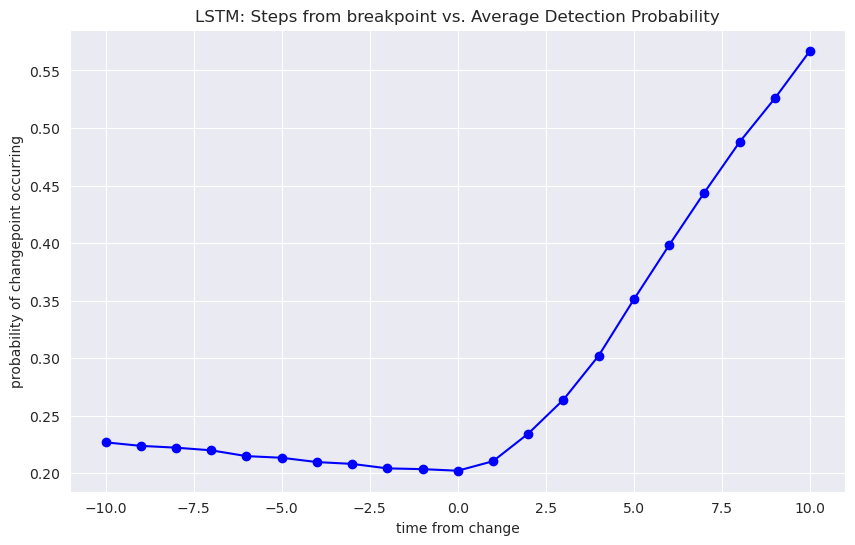

In [61]:
plt.figure(figsize=(10,6))

plt.plot(x_axis, y_axis, marker='o', linestyle='-', color='blue', label='Average Detection Probability')

plt.title('LSTM: Steps from breakpoint vs. Average Detection Probability')
plt.xlabel('time from change')
plt.ylabel('probability of changepoint occurring')

plt.show()

1D-CNN

In [106]:
class AnomalyDetectorCNN(nn.Module):

    def __init__(self, CNN_dropout=0 ,linear_dropout=0):
        super().__init__()

        self.cnn_layer_1_size = 64
        self.cnn_layer_2_size = 128
        self.cnn_layer_3_size = 1024

        self.cnn_layer_final = self.cnn_layer_3_size

        self.cnn_dropout = CNN_dropout

        self.CNN = nn.Sequential(
            nn.Conv1d(in_channels=10, out_channels=self.cnn_layer_1_size, kernel_size=5, padding=2),
            nn.ReLU(),

            nn.Conv1d(in_channels=self.cnn_layer_1_size, out_channels=self.cnn_layer_2_size, kernel_size=3, padding=2),
            nn.ReLU(),

            nn.Conv1d(in_channels=self.cnn_layer_2_size, out_channels=self.cnn_layer_3_size, kernel_size=2, padding=2),
            nn.ReLU(),
        )

        self.linear_layer_1_size = 256
        self.linear_layer_2_size = 100
        self.linear_layer_3_size = 50
        self.linear_layer_4_size = 20
        self.final_output_layer_size = 1


        self.classifier = nn.Sequential(
            nn.Linear(in_features=self.cnn_layer_final, out_features=self.linear_layer_1_size),
            nn.LayerNorm(normalized_shape=self.linear_layer_1_size),
            nn.ReLU(),
            nn.Dropout(p=linear_dropout),

            nn.Linear(in_features=self.linear_layer_1_size, out_features=self.linear_layer_2_size),
            nn.LayerNorm(normalized_shape=self.linear_layer_2_size),
            nn.ReLU(),
            nn.Dropout(p=linear_dropout),

            nn.Linear(in_features=self.linear_layer_2_size, out_features=self.linear_layer_3_size),
            nn.LayerNorm(normalized_shape=self.linear_layer_3_size),
            nn.ReLU(),
            nn.Dropout(p=linear_dropout),

            nn.Linear(in_features=self.linear_layer_3_size, out_features=self.linear_layer_4_size),
            nn.LayerNorm(normalized_shape=self.linear_layer_4_size),
            nn.ReLU(),
            nn.Dropout(p=linear_dropout),

            nn.Linear(in_features=self.linear_layer_4_size, out_features=self.final_output_layer_size)
        )

    def forward(self, x):

        x = x.transpose(1, 2)

        x = self.CNN(x)

        x = F.adaptive_avg_pool1d(x, 1)

        x = x.squeeze(2)

        logits = self.classifier(x).squeeze(1)

        return logits

In [119]:
# Model Hyperparameters
m2_CNN_dropout = 0.25
m2_linear_dropout = 0.25

# Training Loop Hyperparameter setup
m2_learning_rate = 1e-5
m2_epochs = 30

m2_epoch_over_training_loss = []
m2_epoch_over_testing_loss = []

1D-CNN Training Loop

In [ ]:
model_2 = AnomalyDetectorCNN(
    m2_CNN_dropout,
    m2_linear_dropout
).to(device)

loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_2.parameters(), lr=m2_learning_rate)

print('########## Starting Training Loop for Anomaly Detection CNN ##########\n')

for epoch in range(m2_epochs):

    model_2.train()

    total_training_loss = 0
    total_testing_loss = 0

    avg_training_loss = 0
    avg_testing_loss = 0

    print(f'~~~~~ Epoch {epoch + 1}/{m2_epochs} ~~~~~')

    for X_batch, length_batch, y_batch in tqdm(train_dataloader, desc='Training', unit=' batches'):
        optimizer.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.float().to(device)

        logits = model_2(X_batch)

        loss = loss_function(logits, y_batch)

        with torch.no_grad():
            total_training_loss += loss.item()

        loss.backward()
        optimizer.step()

    model_2.eval()

    # Calc testing loss
    with torch.no_grad():
        for X_t_batch, length_t_batch, y_t_batch in tqdm(test_dataloader, desc='Testing', unit=' batches'):
                X_t_batch = X_t_batch.to(device)
                y_t_batch = y_t_batch.float().to(device)

                t_logits = model_2(X_t_batch)

                total_testing_loss += loss_function(t_logits, y_t_batch).item()

        avg_training_loss = total_training_loss / len(train_dataloader)
        avg_testing_loss = total_testing_loss / len(test_dataloader)

    m2_epoch_over_training_loss.append({
        'epoch': epoch + 1,
        'training_loss': avg_training_loss,
    })

    m2_epoch_over_testing_loss.append({
        'epoch': epoch + 1,
        'testing_loss': avg_testing_loss,
    })

    print(f'     -> Training Loss: {avg_training_loss:.4f}\n')
    print(f'     -> Testing Loss: {avg_testing_loss:.4f}\n')

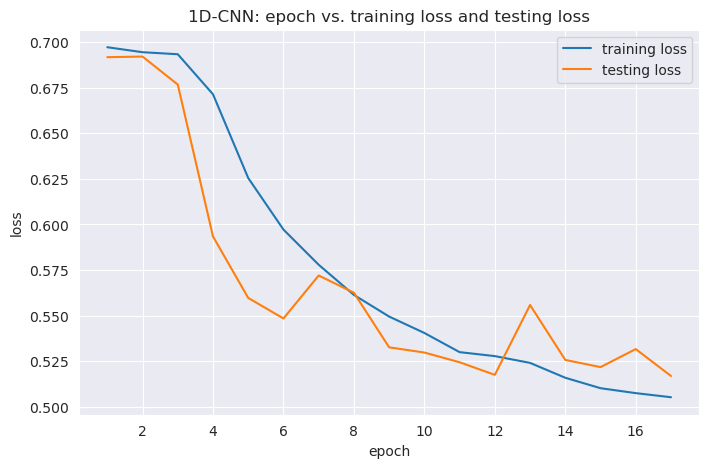

In [121]:
m2_x_axis = [d["epoch"] for d in m2_epoch_over_training_loss]
m2_y_axis_1 = [d["training_loss"] for d in m2_epoch_over_training_loss]
m2_y_axis_2 = [d["testing_loss"] for d in m2_epoch_over_testing_loss]

plt.figure(figsize=(8,5))
plt.title("1D-CNN: epoch vs. training loss and testing loss")
plt.plot(m2_x_axis, m2_y_axis_1, label="training loss")
plt.plot(m2_x_axis, m2_y_axis_2, label="testing loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()


plt.show()

Time Step Probability Detection Graphing for 1D-CNN

In [122]:
model_2.eval()

plot_range = range(-10, 11)

probability_by_r_dict = {r: [] for r in plot_range}

plot_data_dataloader = DataLoader(
    generate_plot_data(),
    batch_size=m_batch_size,
    shuffle=False,
    collate_fn=generate_padded_plot_data
)

with torch.no_grad():
    for x_batch, length_batch, y_batch, r_batch in tqdm(plot_data_dataloader, desc='Evaluating', unit=' batches'):

        x_batch = x_batch.to(device)
        y_batch = y_batch.float().to(device)

        logits = model_2(x_batch)

        probabilities = torch.sigmoid(logits).cpu().numpy()

        r_indices = r_batch.cpu().numpy()

        for probability, r_value in zip(probabilities, r_indices):
            probability_by_r_dict[r_value].append(probability)

x_axis = sorted(probability_by_r_dict.keys())
y_axis = [
    np.mean(probability_by_r_dict[r]) for r in plot_range
]


Evaluating: 100%|██████████| 1969/1969 [00:01<00:00, 1550.13 batches/s]


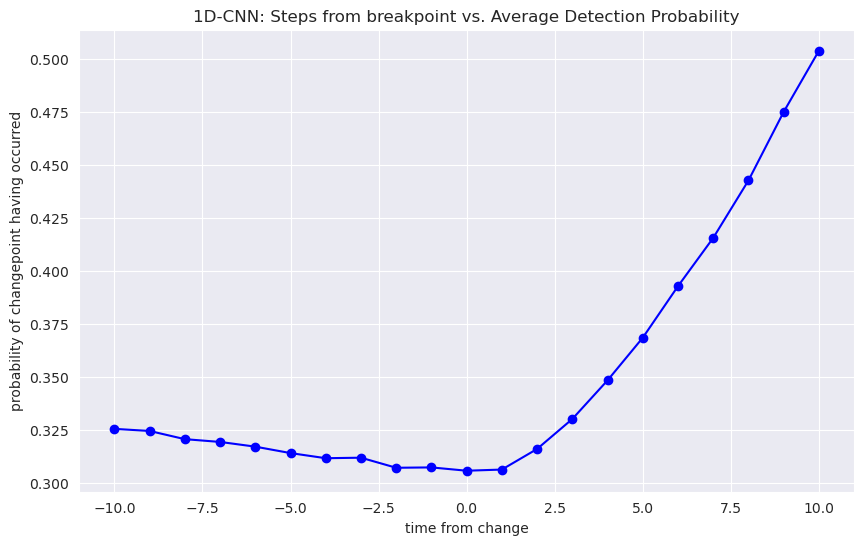

In [124]:
plt.figure(figsize=(10,6))

plt.plot(x_axis, y_axis, marker='o', linestyle='-', color='blue', label='Average Detection Probability')

plt.title('1D-CNN: Steps from breakpoint vs. Average Detection Probability')
plt.xlabel('time from change')
plt.ylabel('probability of changepoint having occurred')

plt.show()

Time Horizon data graphing for LSTM and 1D-CNN

In [125]:
example_dataloader = DataLoader(
    generate_data_tensors(custom_sequence_range=range(100, 201)),
    batch_size=m_batch_size,
    shuffle=True,
    collate_fn=generate_padded_data
)

In [126]:
# Calc testing loss

print('### Attempting Outside Time-Horizon Data Collecting')

model_1_testing_loss = 0
model_2_testing_loss = 0

with torch.no_grad():
    for X_t_batch, length_t_batch, y_t_batch in tqdm(example_dataloader, desc='Testing', unit=' batches'):
            X_t_batch = X_t_batch.to(device)
            y_t_batch = y_t_batch.float().to(device)

            t_logits = model(X_t_batch, length_t_batch)

            model_1_testing_loss += loss_function(t_logits, y_t_batch).item()

with torch.no_grad():
    for X_t_batch, length_t_batch, y_t_batch in tqdm(example_dataloader, desc='Testing', unit=' batches'):
            X_t_batch = X_t_batch.to(device)
            y_t_batch = y_t_batch.float().to(device)

            t_logits = model_2(X_t_batch)

            model_2_testing_loss += loss_function(t_logits, y_t_batch).item()

avg_model_1_testing_loss = model_1_testing_loss / len(example_dataloader)
avg_model_2_testing_loss = model_2_testing_loss / len(example_dataloader)

print(f'Model 1 Testing Loss: {avg_model_1_testing_loss:.4f}')
print(f'Model 2 Testing Loss: {avg_model_2_testing_loss:.4f}')

### Attempting Outside Time-Horizon Data Collecting


Testing: 100%|██████████| 632/632 [00:00<00:00, 684.44 batches/s]

Model 1 Testing Loss: 0.2160
Model 2 Testing Loss: 0.3686


### Question 2 Code and Setup

Data generation and collection for summary and query network

In [20]:
def generate_int_sequence_dataset(num_of_sequences: int = 100, max_length: int = 10) -> DataWrapper:

    list_of_sequences = []
    list_of_queries = []
    list_of_labels = []

    for _ in range(num_of_sequences):
        sequence_length = random.randint(1, max_length)
        sequence_to_add = generate_int_sequence(sequence_length=sequence_length)

        query_value = torch.tensor(random.randint(1, 9), dtype=torch.int64)
        label_value_tensor = (sequence_to_add == query_value).any().float()

        list_of_sequences.append(sequence_to_add)
        list_of_queries.append(query_value)
        list_of_labels.append(label_value_tensor)

    return DataWrapper(zip(list_of_sequences, list_of_queries, list_of_labels))

def sort_int_sequence_dataset(batch):

    list_of_sequences = [item[0] for item in batch]
    list_of_queries = [item[1] for item in batch]
    list_of_labels = [item[2] for item in batch]

    lengths = torch.tensor([sequence.shape[0] for sequence in list_of_sequences], dtype=torch.int64)

    lengths_sorted, sorted_idx = lengths.sort(descending=True)

    sorted_sequences = [list_of_sequences[i] for i in sorted_idx]
    queries_sorted = [list_of_queries[i] for i in sorted_idx]
    labels_sorted = [list_of_labels[i] for i in sorted_idx]

    padded_sequences = pad_sequence(sorted_sequences, batch_first=True, padding_value=0.0)
    query_tensor = torch.stack(queries_sorted, dim=0)
    label_tensor = torch.stack(labels_sorted, dim=0)

    return padded_sequences, lengths_sorted, query_tensor, label_tensor

Summary and Query Network

In [21]:
class IntPredictorLSTM(nn.Module):

    def __init__(self, embedding_dim: int = 2, num_of_ints: int = 10,
                 hidden_size=10,
                 LSTM_layers=1,
                 LSTM_dropout: float = 0,
                 linear_dropout: float = 0,
                 bidirectional=False
                 ):
        super().__init__()

        self.embedding = nn.Embedding(num_embeddings=num_of_ints, embedding_dim=embedding_dim)

        self.summary = nn.LSTM(
                            input_size=embedding_dim,
                            hidden_size=hidden_size,
                            num_layers=LSTM_layers,
                            dropout=LSTM_dropout,
                            bidirectional=bidirectional,
                            batch_first=True
        )

        self.q_layer_1_size = 200
        self.q_layer_2_size = 200
        self.q_layer_3_size = 100
        self.q_layer_4_size = 50
        self.q_layer_5_size = 1

        self.query = nn.Sequential(
            nn.Linear(in_features=embedding_dim + hidden_size, out_features=self.q_layer_1_size),
            nn.ReLU(),
            nn.Dropout(p=linear_dropout),

            nn.Linear(in_features=self.q_layer_1_size, out_features=self.q_layer_2_size),
            nn.ReLU(),
            nn.Dropout(p=linear_dropout),

            nn.Linear(in_features=self.q_layer_2_size, out_features=self.q_layer_3_size),
            nn.ReLU(),
            nn.Dropout(p=linear_dropout),

            nn.Linear(in_features=self.q_layer_3_size, out_features=self.q_layer_4_size),
            nn.ReLU(),
            nn.Dropout(p=linear_dropout),

            nn.Linear(in_features=self.q_layer_4_size, out_features=self.q_layer_5_size),
        )

    def forward(self, int_seq, query_int, lengths):

        embedded_sequence = self.embedding(int_seq)

        packed_sequence = pack_padded_sequence(embedded_sequence,
                                               lengths.cpu(),
                                               batch_first=True,
                                               enforce_sorted=False)

        lstm_output, (h_n, c_n) = self.summary(packed_sequence)

        summary_vector = h_n[-1]

        embedded_query = self.embedding(query_int)

        combined_input = torch.cat([summary_vector, embedded_query], dim=1)

        logits = self.query(combined_input).squeeze(1)

        return logits




In [22]:
m3_train_dataloader = DataLoader(
    generate_int_sequence_dataset(num_of_sequences=100000, max_length=10),
    batch_size=32,
    shuffle=True,
    pin_memory=True,
    num_workers=5,
    collate_fn=sort_int_sequence_dataset
)

m3_test_dataloader = DataLoader(
    generate_int_sequence_dataset(num_of_sequences=30000, max_length=10),
    batch_size=32,
    shuffle=False,
    pin_memory=True,
    num_workers=5,
    collate_fn=sort_int_sequence_dataset
)

In [29]:
# Model Hyperparameter setup
m3_hidden_size = 10
m3_LSTM_layers = 3
m3_LSTM_dropout = 0
m3_linear_dropout = 0
is_bidirectional = True
# weight_decay = 5e-4

# Training Loop Hyperparameter setup
m3_learning_rate = 1e-3
m3_epochs = 50

m3_epoch_over_training_loss = []
m3_epoch_over_testing_loss = []

Training Loop for Summary and Query Network

In [30]:
# Setup model, optimizer, and loss function
model_3 = IntPredictorLSTM(
    hidden_size=m3_hidden_size,
    LSTM_layers=m3_LSTM_layers,
    LSTM_dropout=m3_LSTM_dropout,
    linear_dropout=m3_linear_dropout,
    bidirectional=is_bidirectional
).to(device)

loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model_3.parameters(),
                        lr=m3_learning_rate,
                        # weight_decay=weight_decay
                        )

print('########## Starting Training Loop for Int Sequence Query LSTM ##########\n')

for epoch in range(m3_epochs):

    model_3.train()

    total_training_loss = 0
    total_testing_loss = 0

    avg_training_loss = 0
    avg_testing_loss = 0

    print(f'~~~~~ Epoch {epoch + 1}/{m3_epochs} ~~~~~')

    for X_batch, length_batch, query_batch, y_batch in tqdm(m3_train_dataloader, desc='Training', unit=' batches'):
        optimizer.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        query_batch = query_batch.to(device)

        logits = model_3(X_batch, query_batch, length_batch)

        loss = loss_function(logits, y_batch)

        with torch.no_grad():
            total_training_loss += loss.item()

        loss.backward()
        optimizer.step()

    model_3.eval()

    # Calc testing loss
    with torch.no_grad():
        for X_t_batch, length_t_batch, query_t_batch, y_t_batch in tqdm(m3_test_dataloader, desc='Testing', unit=' batches'):
                X_t_batch = X_t_batch.to(device)
                y_t_batch = y_t_batch.to(device)
                query_t_batch = query_t_batch.to(device)

                t_logits = model_3(X_t_batch, query_t_batch, length_t_batch)

                total_testing_loss += loss_function(t_logits, y_t_batch).item()

        avg_training_loss = total_training_loss / len(m3_train_dataloader)
        avg_testing_loss = total_testing_loss / len(m3_test_dataloader)

    model_3.train()

    m3_epoch_over_training_loss.append({
        'epoch': epoch + 1,
        'training_loss': avg_training_loss,
    })

    m3_epoch_over_testing_loss.append({
        'epoch': epoch + 1,
        'testing_loss': avg_testing_loss,
    })

    print(f'     -> Training Loss: {avg_training_loss:.4f}\n')
    print(f'     -> Testing Loss: {avg_testing_loss:.4f}\n')

########## Starting Training Loop for Int Sequence Query LSTM ##########

~~~~~ Epoch 1/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 654.31 batches/s]


     -> Training Loss: 0.4819

     -> Testing Loss: 0.4112

~~~~~ Epoch 2/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 662.75 batches/s]


     -> Training Loss: 0.3873

     -> Testing Loss: 0.3524

~~~~~ Epoch 3/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 684.79 batches/s]


     -> Training Loss: 0.3121

     -> Testing Loss: 0.2813

~~~~~ Epoch 4/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 689.74 batches/s]


     -> Training Loss: 0.2342

     -> Testing Loss: 0.2117

~~~~~ Epoch 5/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 681.05 batches/s]


     -> Training Loss: 0.1987

     -> Testing Loss: 0.1883

~~~~~ Epoch 6/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 676.04 batches/s]


     -> Training Loss: 0.1757

     -> Testing Loss: 0.1641

~~~~~ Epoch 7/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 665.96 batches/s]


     -> Training Loss: 0.1569

     -> Testing Loss: 0.1497

~~~~~ Epoch 8/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 694.49 batches/s]


     -> Training Loss: 0.1406

     -> Testing Loss: 0.1262

~~~~~ Epoch 9/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 667.85 batches/s]


     -> Training Loss: 0.1205

     -> Testing Loss: 0.1092

~~~~~ Epoch 10/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 667.28 batches/s]


     -> Training Loss: 0.1084

     -> Testing Loss: 0.0962

~~~~~ Epoch 11/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 683.35 batches/s]


     -> Training Loss: 0.0938

     -> Testing Loss: 0.0801

~~~~~ Epoch 12/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 679.84 batches/s]


     -> Training Loss: 0.0817

     -> Testing Loss: 0.0689

~~~~~ Epoch 13/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 667.77 batches/s]


     -> Training Loss: 0.0720

     -> Testing Loss: 0.0764

~~~~~ Epoch 14/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 667.84 batches/s]


     -> Training Loss: 0.0649

     -> Testing Loss: 0.0597

~~~~~ Epoch 15/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 668.37 batches/s]


     -> Training Loss: 0.0567

     -> Testing Loss: 0.0450

~~~~~ Epoch 16/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 680.45 batches/s]


     -> Training Loss: 0.0523

     -> Testing Loss: 0.0392

~~~~~ Epoch 17/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 687.26 batches/s]


     -> Training Loss: 0.0387

     -> Testing Loss: 0.0281

~~~~~ Epoch 18/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 631.93 batches/s]


     -> Training Loss: 0.0350

     -> Testing Loss: 0.0176

~~~~~ Epoch 19/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 672.32 batches/s]


     -> Training Loss: 0.0264

     -> Testing Loss: 0.0285

~~~~~ Epoch 20/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 667.32 batches/s]


     -> Training Loss: 0.0224

     -> Testing Loss: 0.0272

~~~~~ Epoch 21/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 656.59 batches/s]


     -> Training Loss: 0.0191

     -> Testing Loss: 0.0178

~~~~~ Epoch 22/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 654.43 batches/s]


     -> Training Loss: 0.0160

     -> Testing Loss: 0.0099

~~~~~ Epoch 23/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 670.60 batches/s]


     -> Training Loss: 0.0120

     -> Testing Loss: 0.0054

~~~~~ Epoch 24/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 670.31 batches/s]


     -> Training Loss: 0.0091

     -> Testing Loss: 0.0023

~~~~~ Epoch 25/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 654.52 batches/s]


     -> Training Loss: 0.0066

     -> Testing Loss: 0.0010

~~~~~ Epoch 26/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 672.61 batches/s]


     -> Training Loss: 0.0038

     -> Testing Loss: 0.0010

~~~~~ Epoch 27/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 664.86 batches/s]


     -> Training Loss: 0.0050

     -> Testing Loss: 0.0010

~~~~~ Epoch 28/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 670.12 batches/s]


     -> Training Loss: 0.0039

     -> Testing Loss: 0.0015

~~~~~ Epoch 29/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 677.05 batches/s]


     -> Training Loss: 0.0037

     -> Testing Loss: 0.0004

~~~~~ Epoch 30/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 657.87 batches/s]


     -> Training Loss: 0.0038

     -> Testing Loss: 0.0109

~~~~~ Epoch 31/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 631.52 batches/s]


     -> Training Loss: 0.0018

     -> Testing Loss: 0.0001

~~~~~ Epoch 32/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 662.76 batches/s]


     -> Training Loss: 0.0023

     -> Testing Loss: 0.0002

~~~~~ Epoch 33/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 663.92 batches/s]


     -> Training Loss: 0.0032

     -> Testing Loss: 0.0021

~~~~~ Epoch 34/50 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 676.16 batches/s]


     -> Training Loss: 0.0012

     -> Testing Loss: 0.0000

~~~~~ Epoch 35/50 ~~~~~


Training:   7%|▋         | 216/3125 [00:01<00:15, 192.89 batches/s]


KeyboardInterrupt: 

In [ ]:
m3_x_axis = [d["epoch"] for d in m3_epoch_over_training_loss]
m3_y_axis_1 = [d["training_loss"] for d in m3_epoch_over_training_loss]
m3_y_axis_2 = [d["testing_loss"] for d in m3_epoch_over_testing_loss]

plt.figure(figsize=(8,5))
plt.title("LSTM Summary and Query: epoch vs. training loss and testing loss")
plt.plot(m3_x_axis, m3_y_axis_1, label="training loss")
plt.plot(m3_x_axis, m3_y_axis_2, label="testing loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()


plt.show()

Summary and Query of two ints in sequence Neural Network

In [37]:
class IntsPredictorLSTM(nn.Module):

    def __init__(self, embedding_dim: int = 2, num_of_ints: int = 10,
                 hidden_size=10,
                 LSTM_layers=1,
                 LSTM_dropout: float = 0,
                 linear_dropout: float = 0,
                 bidirectional=False
                 ):
        super().__init__()

        self.embedding = nn.Embedding(num_embeddings=num_of_ints, embedding_dim=embedding_dim)

        self.summary = nn.LSTM(
                            input_size=embedding_dim,
                            hidden_size=hidden_size,
                            num_layers=LSTM_layers,
                            dropout=LSTM_dropout,
                            bidirectional=bidirectional,
                            batch_first=True
        )

        self.q_layer_1_size = 200
        self.q_layer_2_size = 200
        self.q_layer_3_size = 100
        self.q_layer_4_size = 50
        self.q_layer_5_size = 1

        self.query = nn.Sequential(
            nn.Linear(in_features=(2*embedding_dim) + hidden_size, out_features=self.q_layer_1_size),
            nn.ReLU(),
            nn.Dropout(p=linear_dropout),

            nn.Linear(in_features=self.q_layer_1_size, out_features=self.q_layer_2_size),
            nn.ReLU(),
            nn.Dropout(p=linear_dropout),

            nn.Linear(in_features=self.q_layer_2_size, out_features=self.q_layer_3_size),
            nn.ReLU(),
            nn.Dropout(p=linear_dropout),

            nn.Linear(in_features=self.q_layer_3_size, out_features=self.q_layer_4_size),
            nn.ReLU(),
            nn.Dropout(p=linear_dropout),

            nn.Linear(in_features=self.q_layer_4_size, out_features=self.q_layer_5_size),
        )

    def forward(self, int_seq, query_int, lengths):

        embedded_sequence = self.embedding(int_seq)

        packed_sequence = pack_padded_sequence(embedded_sequence,
                                               lengths.cpu(),
                                               batch_first=True,
                                               enforce_sorted=False)

        lstm_output, (h_n, c_n) = self.summary(packed_sequence)

        summary_vector = h_n[-1]

        embedded_query = self.embedding(query_int)

        embedded_query_1 = self.embedding(query_int + 1)

        combined_input = torch.cat([summary_vector, embedded_query, embedded_query_1], dim=1)

        logits = self.query(combined_input).squeeze(1)

        return logits




Data Generation and Collection of Summary and Query of two ints in sequence Neural Network

In [38]:
def generate_int_sequence(sequence_length: int = 10) -> torch.Tensor:

    return torch.randint(0, 9, size=(sequence_length, ), dtype=torch.int64)

def generate_int_sequence_forced(q: int, sequence_length: int = 10) -> torch.Tensor:

    sequence = torch.randint(0, 10, size=(sequence_length, ), dtype=torch.int64)

    index = random.randint(0, sequence_length - 2)

    value_1 = q
    value_2 = q + 1

    sequence[index] = torch.tensor(value_1, dtype=torch.int64)
    sequence[index + 1] = torch.tensor(value_2, dtype=torch.int64)

    return sequence

def generate_int_sequential_dataset(num_of_sequences: int = 100, max_length: int = 10) -> DataWrapper:

    list_of_sequences = []
    list_of_queries = []
    list_of_labels = []

    length_1, length_2 = int(num_of_sequences * (2/3)), int(num_of_sequences * (1/3))

    for _ in range(length_1):
        sequence_length = random.randint(1, max_length)
        sequence_to_add = generate_int_sequence(sequence_length=sequence_length)

        query_value = torch.tensor(random.randint(0, 8), dtype=torch.int64)

        value_1 = query_value.item()
        value_2 = value_1 + 1

        check_1 = (sequence_to_add[:-1] == value_1)
        check_2 = (sequence_to_add[1:] == value_2)

        label_value_tensor = (check_1 & check_2).any().float()

        list_of_sequences.append(sequence_to_add)
        list_of_queries.append(query_value)
        list_of_labels.append(label_value_tensor)

    for _ in range(length_2):
        sequence_length = random.randint(2, max_length)

        query_tensor = torch.tensor(random.randint(0, 8), dtype=torch.int64)

        query_value = query_tensor.item()

        sequence_to_add = generate_int_sequence_forced(sequence_length=sequence_length,
                                                       q=query_value)

        label_value_tensor = torch.tensor(1.0, dtype=torch.float32)

        list_of_sequences.append(sequence_to_add)
        list_of_queries.append(query_tensor)
        list_of_labels.append(label_value_tensor)

    return DataWrapper(zip(list_of_sequences, list_of_queries, list_of_labels))

In [59]:
# Model Hyperparameter setup
m4_hidden_size = 10
m4_LSTM_layers = 3
m4_LSTM_dropout = 0
m4_linear_dropout = 0
is_bidirectional = True
# weight_decay = 5e-4

# Training Loop Hyperparameter setup
m4_learning_rate = 1e-3
m4_epochs = 30

m4_epoch_over_training_loss = []
m4_epoch_over_testing_loss = []

Training Loop for Summary and Query of two ints in sequence Neural Network

In [60]:
m4_train_dataloader = DataLoader(
    generate_int_sequential_dataset(num_of_sequences=100000, max_length=10),
    batch_size=32,
    shuffle=True,
    pin_memory=True,
    num_workers=5,
    collate_fn=sort_int_sequence_dataset
)

m4_test_dataloader = DataLoader(
    generate_int_sequential_dataset(num_of_sequences=30000, max_length=10),
    batch_size=32,
    shuffle=False,
    pin_memory=True,
    num_workers=5,
    collate_fn=sort_int_sequence_dataset
)

In [61]:
# Setup model, optimizer, and loss function
model_4 = IntsPredictorLSTM(
    hidden_size=m4_hidden_size,
    LSTM_layers=m4_LSTM_layers,
    LSTM_dropout=m4_LSTM_dropout,
    linear_dropout=m4_linear_dropout,
    bidirectional=is_bidirectional
).to(device)

loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model_4.parameters(),
                        lr=m4_learning_rate,
                        # weight_decay=weight_decay
                        )

print('########## Starting Training Loop for Int Sequence Query LSTM ##########\n')

for epoch in range(m4_epochs):

    model_4.train()

    total_training_loss = 0
    total_testing_loss = 0

    avg_training_loss = 0
    avg_testing_loss = 0

    print(f'~~~~~ Epoch {epoch + 1}/{m4_epochs} ~~~~~')

    for X_batch, length_batch, query_batch, y_batch in tqdm(m4_train_dataloader, desc='Training', unit=' batches'):
        optimizer.zero_grad()

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        query_batch = query_batch.to(device)

        logits = model_4(X_batch, query_batch, length_batch)

        loss = loss_function(logits, y_batch)

        with torch.no_grad():
            total_training_loss += loss.item()

        loss.backward()
        optimizer.step()

    model_4.eval()

    # Calc testing loss
    with torch.no_grad():
        for X_t_batch, length_t_batch, query_t_batch, y_t_batch in tqdm(m4_test_dataloader, desc='Testing', unit=' batches'):
                X_t_batch = X_t_batch.to(device)
                y_t_batch = y_t_batch.to(device)
                query_t_batch = query_t_batch.to(device)

                t_logits = model_4(X_t_batch, query_t_batch, length_t_batch)

                total_testing_loss += loss_function(t_logits, y_t_batch).item()

        avg_training_loss = total_training_loss / len(m3_train_dataloader)
        avg_testing_loss = total_testing_loss / len(m3_test_dataloader)

    model_4.train()

    m4_epoch_over_training_loss.append({
        'epoch': epoch + 1,
        'training_loss': avg_training_loss,
    })

    m4_epoch_over_testing_loss.append({
        'epoch': epoch + 1,
        'testing_loss': avg_testing_loss,
    })

    print(f'     -> Training Loss: {avg_training_loss:.4f}\n')
    print(f'     -> Testing Loss: {avg_testing_loss:.4f}\n')

########## Starting Training Loop for Int Sequence Query LSTM ##########

~~~~~ Epoch 1/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 640.21 batches/s]


     -> Training Loss: 0.4538

     -> Testing Loss: 0.3213

~~~~~ Epoch 2/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 638.20 batches/s]


     -> Training Loss: 0.2550

     -> Testing Loss: 0.2427

~~~~~ Epoch 3/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 639.86 batches/s]


     -> Training Loss: 0.2082

     -> Testing Loss: 0.1998

~~~~~ Epoch 4/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 619.41 batches/s]


     -> Training Loss: 0.1686

     -> Testing Loss: 0.1517

~~~~~ Epoch 5/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 664.32 batches/s]


     -> Training Loss: 0.1115

     -> Testing Loss: 0.0717

~~~~~ Epoch 6/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 669.18 batches/s]


     -> Training Loss: 0.0604

     -> Testing Loss: 0.0520

~~~~~ Epoch 7/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 678.25 batches/s]


     -> Training Loss: 0.0342

     -> Testing Loss: 0.0276

~~~~~ Epoch 8/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 631.21 batches/s]


     -> Training Loss: 0.0215

     -> Testing Loss: 0.0128

~~~~~ Epoch 9/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 670.40 batches/s]


     -> Training Loss: 0.0137

     -> Testing Loss: 0.0095

~~~~~ Epoch 10/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 675.18 batches/s]


     -> Training Loss: 0.0097

     -> Testing Loss: 0.0048

~~~~~ Epoch 11/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 673.16 batches/s]


     -> Training Loss: 0.0081

     -> Testing Loss: 0.0032

~~~~~ Epoch 12/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 660.92 batches/s]


     -> Training Loss: 0.0062

     -> Testing Loss: 0.0027

~~~~~ Epoch 13/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 681.20 batches/s]


     -> Training Loss: 0.0061

     -> Testing Loss: 0.0059

~~~~~ Epoch 14/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 693.35 batches/s]


     -> Training Loss: 0.0049

     -> Testing Loss: 0.0046

~~~~~ Epoch 15/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 618.87 batches/s]


     -> Training Loss: 0.0034

     -> Testing Loss: 0.0039

~~~~~ Epoch 16/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 644.69 batches/s]


     -> Training Loss: 0.0036

     -> Testing Loss: 0.0033

~~~~~ Epoch 17/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 674.29 batches/s]


     -> Training Loss: 0.0042

     -> Testing Loss: 0.0016

~~~~~ Epoch 18/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 578.03 batches/s]


     -> Training Loss: 0.0035

     -> Testing Loss: 0.0010

~~~~~ Epoch 19/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 629.75 batches/s]


     -> Training Loss: 0.0029

     -> Testing Loss: 0.0017

~~~~~ Epoch 20/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 562.77 batches/s]


     -> Training Loss: 0.0027

     -> Testing Loss: 0.0016

~~~~~ Epoch 21/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 565.52 batches/s]


     -> Training Loss: 0.0028

     -> Testing Loss: 0.0022

~~~~~ Epoch 22/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 661.54 batches/s]


     -> Training Loss: 0.0024

     -> Testing Loss: 0.0018

~~~~~ Epoch 23/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 703.99 batches/s]


     -> Training Loss: 0.0031

     -> Testing Loss: 0.0004

~~~~~ Epoch 24/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 640.51 batches/s]


     -> Training Loss: 0.0028

     -> Testing Loss: 0.0011

~~~~~ Epoch 25/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 581.80 batches/s]


     -> Training Loss: 0.0027

     -> Testing Loss: 0.0013

~~~~~ Epoch 26/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 522.29 batches/s]


     -> Training Loss: 0.0011

     -> Testing Loss: 0.0169

~~~~~ Epoch 27/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 655.62 batches/s]


     -> Training Loss: 0.0047

     -> Testing Loss: 0.0016

~~~~~ Epoch 28/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 639.71 batches/s]


     -> Training Loss: 0.0022

     -> Testing Loss: 0.0011

~~~~~ Epoch 29/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 655.18 batches/s]


     -> Training Loss: 0.0020

     -> Testing Loss: 0.0030

~~~~~ Epoch 30/30 ~~~~~


Testing: 100%|██████████| 938/938 [00:01<00:00, 663.20 batches/s]

     -> Training Loss: 0.0020

     -> Testing Loss: 0.0013



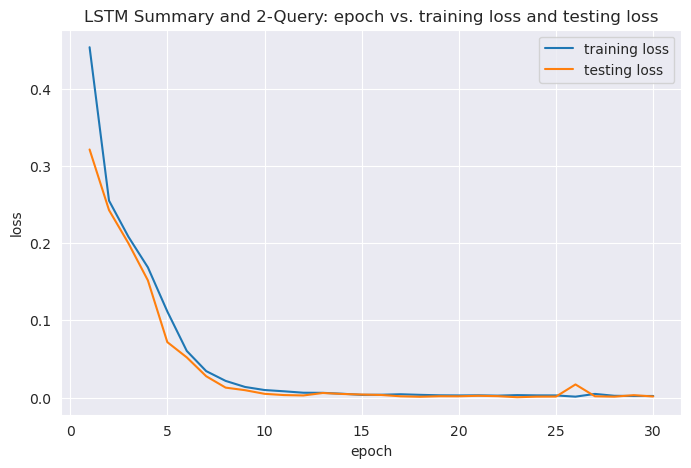

In [62]:
m4_x_axis = [d["epoch"] for d in m4_epoch_over_training_loss]
m4_y_axis_1 = [d["training_loss"] for d in m4_epoch_over_training_loss]
m4_y_axis_2 = [d["testing_loss"] for d in m4_epoch_over_testing_loss]

plt.figure(figsize=(8,5))
plt.title("LSTM Summary and 2-Query: epoch vs. training loss and testing loss")
plt.plot(m4_x_axis, m4_y_axis_1, label="training loss")
plt.plot(m4_x_axis, m4_y_axis_2, label="testing loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()


plt.show()

Graphing of Embeddings made from models in Question 2

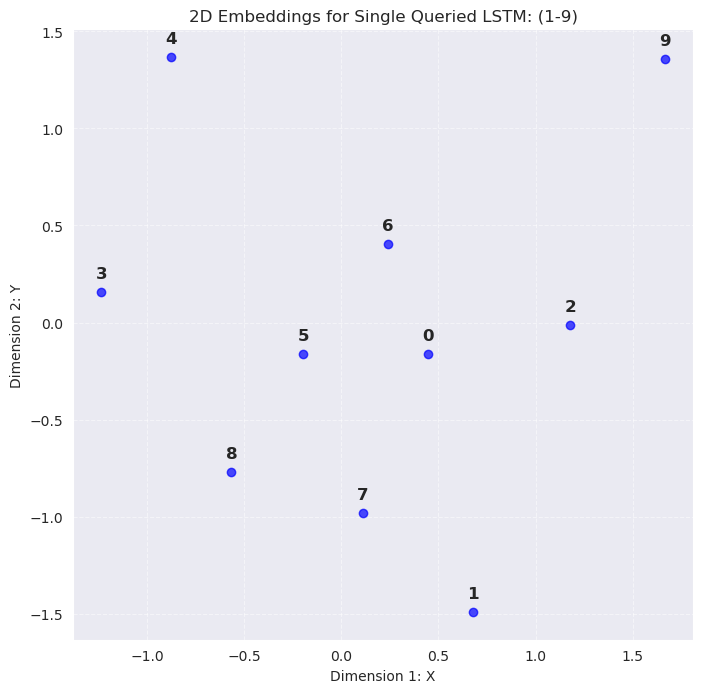

In [66]:
m3_embedding_matrix = model_3.embedding.weight.data.cpu().numpy()

x_coords = m3_embedding_matrix[:, 0]
y_coords = m3_embedding_matrix[:, 1]

plt.figure(figsize=(8, 8))

plt.scatter(x_coords, y_coords, marker='o', color='blue', alpha=0.7)

# For each digit that was embedded
for i in range(10):

    plt.annotate(
        str(i),
        (x_coords[i], y_coords[i]),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontsize=12,
        fontweight='bold'
    )

plt.title('2D Embeddings for Single Queried LSTM: (1-9)')
plt.xlabel('Dimension 1: X')
plt.ylabel('Dimension 2: Y')
plt.grid(True, linestyle='--', alpha=0.5)

plt.gca().set_aspect('equal', adjustable='box')

plt.show()

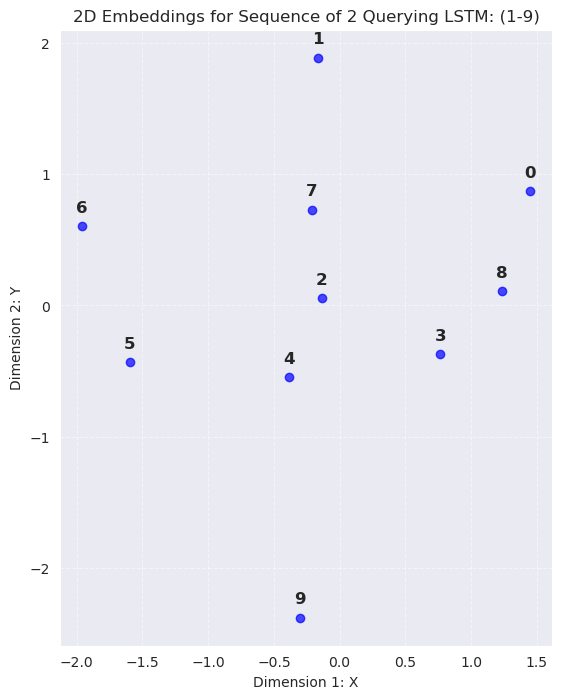

In [68]:
m4_embedding_matrix = model_4.embedding.weight.data.cpu().numpy()

x_coords = m4_embedding_matrix[:, 0]
y_coords = m4_embedding_matrix[:, 1]

plt.figure(figsize=(8, 8))

plt.scatter(x_coords, y_coords, marker='o', color='blue', alpha=0.7)

# For each digit that was embedded
for i in range(10):

    plt.annotate(
        str(i),
        (x_coords[i], y_coords[i]),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontsize=12,
        fontweight='bold'
    )

plt.title('2D Embeddings for Sequence of 2 Querying LSTM: (1-9)')
plt.xlabel('Dimension 1: X')
plt.ylabel('Dimension 2: Y')
plt.grid(True, linestyle='--', alpha=0.5)

plt.gca().set_aspect('equal', adjustable='box')

plt.show()